<a href="https://colab.research.google.com/github/renandcl/Water-pipe_routing_in_the_Brazilian_semi-arid_region/blob/main/Heuristic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heurística do vizinho mais próximo para roterização de caminhões pipa


## 0.Importar dados

In [ ]:
# !pip install july

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, date
from pandas.tseries.holiday import AbstractHolidayCalendar, GoodFriday,\
    Holiday, Easter, Day
import time


In [ ]:
#Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [1]:
dfs = {}

for planilha in planilhas.keys():
    id = planilhas[planilha]['id']
    arquivo = planilhas[planilha]['arquivo']

    file = drive.CreateFile({'id':id})
    file.GetContentFile(arquivo)

    dfs[planilha] = pd.read_excel(arquivo)

NameError: ignored

In [ ]:
ativ = dfs['beneficiarios_ativos']
ativ['id'] = dfs['beneficiarios_ativos'].index
n_ativ = dfs['beneficiarios_n_ativos']
n_ativ['id'] = dfs['beneficiarios_n_ativos'].index
beneficiarios_total = pd.concat([ativ, n_ativ],ignore_index=True)

In [ ]:
file = drive.CreateFile({'id':df_rotas_id})
file.GetContentFile(df_rotas_arquivo)
df_rotas = pd.read_hdf(df_rotas_arquivo, 'df')
df_rotas = df_rotas[['id_beneficiario','id_fonte','distance']]

## 1.Preprocessamento

### 1.1. Calcular a matriz de distâncias/custo entre os beneficiários e fontes.


In [ ]:
dfs['mananciais']['Situação Estrada de Acesso'].unique()

mananciais = dfs['mananciais']
mananciais['multiplicador'] = mananciais['Situação Estrada de Acesso'].replace({
    'Não definido': 0.79,
    'Regular': 0.71,
    'Boa': 0.68,
    np.nan: 0.74
})

# array(['Não definido', 'Regular', nan, 'Boa', 'Ruim'], dtype=object)
beneficiarios_total['multiplicador'] = beneficiarios_total['Situação Estrada de Acesso'].replace({
    'Não definido': 0.79,
    'Regular': 0.71,
    'Boa': 0.68,
    'Ruim': 0.79,
    np.nan: 0.74
})


# adicionando o multiplicador ao df_rotas, se não tiver, preenche com 0.74 de prevalência de chão para estrada mista
df_rotas['multiplicador_manancial'] = df_rotas['id_fonte'].map(mananciais['multiplicador']).fillna(0.74)

# adicionando o multiplicador ao df_rotas, se não tiver, preenche com 0.74 de prevalência de chão para estrada mista
df_rotas['multiplicador_beneficiario'] = df_rotas['id_beneficiario'].map(beneficiarios_total['multiplicador']).fillna(0.74)

# calcula a distância com o multiplicador
df_rotas['distance_w_factor'] = df_rotas['distance'] * np.maximum(df_rotas['multiplicador_manancial'], df_rotas['multiplicador_beneficiario'])

df_rotas

#  Renumeração = Volume Transportado (VT) x Distância do Manancial ao Ponto de Abastecimento x Quantidade de Viagens Realizadas x Índice Multiplicador.



,id_beneficiario,id_fonte,distance,multiplicador_manancial,multiplicador_beneficiario,distance_w_factor
0,0,0,83.6558,0.79,0.79,66.088082
1,1,0,85.3909,0.79,0.79,67.458811
2,2,0,88.8581,0.79,0.79,70.197899
3,3,0,82.8056,0.79,0.79,65.416424
4,4,0,89.6129,0.79,0.79,70.794191
...,...,...,...,...,...,...
304975,3310,91,191.4714,0.68,0.74,141.688836
304976,3311,91,188.2417,0.68,0.74,139.298858
304977,3312,91,214.6769,0.68,0.74,158.860906
304978,3313,91,202.7835,0.68,0.74,150.059790


In [ ]:
df_rotas.loc[df_rotas['id_beneficiario'] == 2888].style.background_gradient(cmap='viridis')

,id_beneficiario,id_fonte,distance,multiplicador_manancial,multiplicador_beneficiario,distance_w_factor
2888,2888,0,85.053300,0.790000,0.740000,67.192107
6203,2888,1,194.771500,0.790000,0.740000,153.869485
9518,2888,2,93.346900,0.790000,0.740000,73.744051
12833,2888,3,82.792700,0.790000,0.740000,65.406233
16148,2888,4,113.997700,0.790000,0.740000,90.058183
19463,2888,5,82.692500,0.790000,0.740000,65.327075
22778,2888,6,154.153200,0.790000,0.740000,121.781028
26093,2888,7,148.188300,0.790000,0.740000,117.068757
29408,2888,8,65.819500,0.790000,0.740000,51.997405
32723,2888,9,213.532900,0.790000,0.740000,168.690991


### 1.2. Dado o estado inicial da cisterna e consumo médio, calcular intervalos e cronograma e de reabastecimento em 1 ano para dias úteis.

In [ ]:
class Feriados_RN(AbstractHolidayCalendar):
    rules = [
        Holiday('Confraternização Universal', month=1, day=1),
        Holiday('Segunda-Feira de Carnaval', month=1, day=1, offset=[Easter(), Day(-48)]),
        Holiday('Terça-Feira de Carnaval', month=1, day=1, offset=[Easter(), Day(-47)]),
        Holiday('Quarta-Feira de Cinzas', month=1, day=1, offset=[Easter(), Day(-46)]),
        GoodFriday, # Sexta-feira Santa
        Holiday('Corpus Christi', month=1, day=1, offset=[Easter(), Day(60)]),
        Holiday('Tiradentes', month = 4, day = 21),
        Holiday('Dia do Trabalho', month = 5, day = 1),
        Holiday('Independência do Brasil', month = 9, day = 7),
        Holiday('Mártires de Cunhaú e Uruaçu', month = 10, day = 3),
        Holiday('Nossa Senhora Aparecida', month = 10, day = 12),
        Holiday('Finados', month = 11, day = 2),
        Holiday('Proclamação da República', month = 11, day = 15),
        Holiday('Natal', month = 12, day = 25)]

rn_cal = Feriados_RN()
rn_feriados = pd.offsets.CustomBusinessDay(calendar=rn_cal)
feriados_rn = rn_cal.holidays(datetime(2000, 12, 31), datetime(2079, 12, 31))

start = datetime(2023, 1, 1)
end = datetime(2023, 12, 31)
dia_util = pd.bdate_range(start, end, freq='C', holidays=feriados_rn) # type: ignore

dia_nao_util = pd.date_range(start, end).difference(dia_util)


In [ ]:
capacidade_cisterna = beneficiarios_total['Capacidade (m³)']

consumo_diario = beneficiarios_total['Num. Pessoas Atendidas']*20/1000

consumo_diario[consumo_diario == 0] = 1*20/1000

capacidade_cisterna[capacidade_cisterna == 0] = 16

# criar vetor preenchido com valor 13 de comprimento igual ao número de beneficiários, representa a capacidade do caminhão
capacidade_caminhao = np.full(len(beneficiarios_total), 13)

n_caminhoes = np.ceil(consumo_diario/capacidade_caminhao)

<ipython-input-38-583838785415>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  capacidade_cisterna[capacidade_cisterna == 0] = 16


In [ ]:
# Criar uma coluna de volume inicial com valores aleatórios entre 0 e 1 vezes a capacidade
np.random.seed(42)
# volume_inicial = (np.random.rand(len(beneficiarios_total)) * beneficiarios_total['Capacidade (m³)']).astype(int)
volume_inicial = beneficiarios_total['Capacidade (m³)']

# Criar um DataFrame com as datas de abastecimento para cada beneficiário e o volume inicial
df_volume = pd.DataFrame(index=beneficiarios_total.index,columns=pd.date_range(start, end))
df_volume[start] = volume_inicial

start_time = time.time()

# Calcular o volume para cada dia
for i in range(1, len(df_volume.columns)):

    if df_volume.columns[i] in dia_nao_util:
        df_volume.iloc[:, i] = df_volume.iloc[:, i-1] - consumo_diario.values

    else:
        df_volume.iloc[:, i] = df_volume.iloc[:, i-1] - consumo_diario.values

        # Se o volume estiver menor que capacidade do caminhão, abastecer com capacidade do caminhão
        df_volume.iloc[:, i] = np.where(df_volume.iloc[:, i].values < capacidade_cisterna - capacidade_caminhao, df_volume.iloc[:, i] + capacidade_caminhao, df_volume.iloc[:, i].values)

        # Se o volume estiver menor igual a 0, abastecer com capacidade do caminhão
        df_volume.iloc[:, i] = np.where(df_volume.iloc[:, i].values <= 0, capacidade_caminhao, df_volume.iloc[:, i].values)

        # se próximo dia for dia não útil e o volume for menor 0, abastecer com capacidade do caminhão
        if i+1 < len(df_volume.columns) and df_volume.columns[i+1] in dia_nao_util:
            df_volume.iloc[:, i] = np.where(df_volume.iloc[:, i].values - consumo_diario.values * 2 <= 0, df_volume.iloc[:, i] + capacidade_caminhao, df_volume.iloc[:, i].values)

        # se os próximos 2 dias forem não útil e o volume for menor 0, abastecer com capacidade do caminhão
        if i+2 < len(df_volume.columns) and df_volume.columns[i+1] in dia_nao_util and df_volume.columns[i+2] in dia_nao_util:
            df_volume.iloc[:, i] = np.where(df_volume.iloc[:, i].values - consumo_diario.values* 3 <= 0, df_volume.iloc[:, i] + capacidade_caminhao, df_volume.iloc[:, i].values)

        # se os próximos 3 dias forem não útil e o volume for menor 0, abastecer com capacidade do caminhão
        if i+3 < len(df_volume.columns) and df_volume.columns[i+1] in dia_nao_util and df_volume.columns[i+2] in dia_nao_util and df_volume.columns[i+3] in dia_nao_util:
            df_volume.iloc[:, i] = np.where(df_volume.iloc[:, i].values - consumo_diario.values * 4 <= 0, df_volume.iloc[:, i] + capacidade_caminhao, df_volume.iloc[:, i].values)

        # se os próximos 4 dias forem não útil e o volume for menor 0, abastecer com capacidade do caminhão
        if i+4 < len(df_volume.columns) and df_volume.columns[i+1] in dia_nao_util and df_volume.columns[i+2] in dia_nao_util and df_volume.columns[i+3] in dia_nao_util and df_volume.columns[i+4] in dia_nao_util:
            df_volume.iloc[:, i] = np.where(df_volume.iloc[:, i].values - consumo_diario.values * 5 <= 0, df_volume.iloc[:, i] + capacidade_caminhao, df_volume.iloc[:, i].values)

        # Se o volume estiver maior que a capacidade da cisterna, abastecer com a capacidade da cisterna
        df_volume.iloc[:, i] = np.where(df_volume.iloc[:, i].values > capacidade_cisterna, capacidade_cisterna, df_volume.iloc[:, i].values)

print("Tempo para cálculo de volumes: {} segundos".format(round(time.time()-start_time, 2)))

<ipython-input-41-0e65908e1b9a>:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_volume.iloc[:, i] = df_volume.iloc[:, i-1] - consumo_diario.values
<ipython-input-41-0e65908e1b9a>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_volume.iloc[:, i] = df_volume.iloc[:, i-1] - consumo_diario.values


Tempo para cálculo de volumes: 5.41 segundos


### 1.3. Calcular quantidades de reabastecimentos por beneficiário.

In [ ]:
# volume abastecido, rolagem de volume por dia, se volume for maior que zero, retorna o a diferença entre o volume do dia anterior e o volume do dia atual
df_abastecimento = (df_volume.diff(axis=1).fillna(0).clip(lower=0,upper=1)).astype(int)

<ipython-input-42-0a65d743ffd5>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_abastecimento = (df_volume.diff(axis=1).fillna(0).clip(lower=0,upper=1)).astype(int)


### 1.4. Ordenar os beneficiários com maior quantidades de reabastecimentos.


In [ ]:
ordem_beneficiaros = df_abastecimento.loc[df_rotas.id_beneficiario.unique(), :].sum(axis=1).sort_values(ascending=False).index.values

### 1.5. Preparação dos dados

In [ ]:
# Criar um DataFrame com o custo de cada rota
volume_anual = df_volume.diff(axis=1).fillna(0).clip(lower=0).replace(0, np.nan).mean(axis=1).replace(np.nan,0) * df_abastecimento.sum(axis=1)
df_rotas['custo'] = df_rotas['id_beneficiario'].map(volume_anual) * df_rotas['distance_w_factor']
df_custo = df_rotas.pivot(index='id_fonte', columns='id_beneficiario', values='custo').values
df_custo.shape

<ipython-input-44-d8a4b8a6e7ef>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  volume_anual = df_volume.diff(axis=1).fillna(0).clip(lower=0).replace(0, np.nan).mean(axis=1).replace(np.nan,0) * df_abastecimento.sum(axis=1)


(92, 3315)

In [ ]:
# parametros
qtd_fontes = len(df_rotas.id_fonte.unique()) # fontes de origem
qtd_beneficiarios = len(df_rotas.id_beneficiario.unique()) # beneficiários
periodo = len(df_volume.columns) # dias
qtd_abastecimentos_diario = df_abastecimento.values # tensor de abastecimento



limite_de_abastecimentos_por_dia = 12 # quantidade limite de abastecimentos por dia na fonte

## 2. Roteirização:


2.1. **Para cada** beneficiário:

2.1.1. **Obter a fonte** mais próxima/menor custo:

2.1.1.1. **Calcular a fonte** mais próxima/menor custo.

2.1.1.2. **Se** a fonte sobrepor limite de abastecimento diário, desconsiderar fonte para beneficiário e **Obter a fonte** mais próxima/menor custo.

2.1.2. Definir como fonte do beneficiário.

### Inicializar variáveis de decisão

In [ ]:
##### variável de decisão
# x[i,j] = abastecimento para o beneficiário j a partir da fonte i
x = np.zeros((qtd_fontes,qtd_beneficiarios))
# y[i,t] = quantidade de caminhões disponíveis na fonte i
y = np.zeros((qtd_fontes,periodo))


### Função recursiva - Obter fonte

In [ ]:
def get_id_of_min_dist_from_source(j,rank):
    if rank == qtd_fontes:
        print('Não foi possível encontrar uma rota para o beneficiário {}'.format(j))
    # get the source id i with the rank-th minimum distance to the beneficiary j from df_rotas_pivot
    i = np.argpartition(df_custo[:,j], rank)[rank]
    # if y plus the amount of trucks needed to supply the beneficiary is less than the total amount of trucks
    if (y[i,:] + qtd_abastecimentos_diario[j,:] > limite_de_abastecimentos_por_dia).any():
        # then try the next rank
        return get_id_of_min_dist_from_source(j,rank+1)
    return i

### Cálculo heurístico

In [ ]:
start_time = time.time()

for j in ordem_beneficiaros:
    # find the source id i with minimum distance to the beneficiary j from df_rotas_pivot
    i = np.argmin(df_custo[:,j])
    # if y plus the amount of trucks needed to supply the beneficiary is less than the total amount of trucks
    if (y[i,:] + qtd_abastecimentos_diario[j,:] <= limite_de_abastecimentos_por_dia).all():
        # then supply the beneficiary
        x[i,j] = 1
        # and add the amount of trucks needed to supply the beneficiary to the total amount of trucks
        y[i,:] += qtd_abastecimentos_diario[j,:]
    else:
        i = get_id_of_min_dist_from_source(j,1)
        x[i,j] = 1
        y[i,:] += qtd_abastecimentos_diario[j,:]

print("Tempo para cálculo da fonte mais próxima para beneficiário: {} segundos".format(round(time.time()-start_time, 2)))

Tempo para cálculo dos pares de fonte e beneficiário: 0.41 segundos


### Resultado individual

In [ ]:
custo_original = volume_anual * beneficiarios_total['Dist. Principal Manancial (Km)'] * beneficiarios_total['multiplicador']
custo_original = custo_original[:qtd_beneficiarios]

custo_final = np.zeros(qtd_beneficiarios)

# print pairs of source and beneficiary
for j in range(qtd_beneficiarios):
    for i in range(qtd_fontes):
        if x[i,j] == 1:
            print("a fonte {i}, abastece o beneficiário {j}, com {qtd} caminhão(ões) no ano, com variação de {dist} na remuneração de referência".format(i=i,j=j,qtd=qtd_abastecimentos_diario[j,:].sum(),dist = round( df_custo[i,j] - custo_original[j],0)))
            custo_final[j] = df_custo[i,j]

a fonte 44, abastece o beneficiário 0, com 5 caminhão(ões) no ano, com variação de -779.0 na remuneração de referência
a fonte 11, abastece o beneficiário 1, com 5 caminhão(ões) no ano, com variação de -575.0 na remuneração de referência
a fonte 10, abastece o beneficiário 2, com 8 caminhão(ões) no ano, com variação de -979.0 na remuneração de referência
a fonte 12, abastece o beneficiário 3, com 5 caminhão(ões) no ano, com variação de -461.0 na remuneração de referência
a fonte 21, abastece o beneficiário 4, com 6 caminhão(ões) no ano, com variação de -450.0 na remuneração de referência
a fonte 10, abastece o beneficiário 5, com 14 caminhão(ões) no ano, com variação de -1674.0 na remuneração de referência
a fonte 12, abastece o beneficiário 6, com 5 caminhão(ões) no ano, com variação de -446.0 na remuneração de referência
a fonte 5, abastece o beneficiário 7, com 3 caminhão(ões) no ano, com variação de -67.0 na remuneração de referência
a fonte 11, abastece o beneficiário 8, com 5 cam

### Custo Operacional

In [ ]:
pct_diff = ((custo_final - custo_original).sum()/custo_original.sum())* 100

print('Custo original: R$ {0:,}'.format(round(custo_original.sum(),2)))
print('Custo final: R$ {0:,}'.format(round(custo_final.sum(),2)))
print ('Redução de {}% no custo total'.format(round(pct_diff,2)))

Custo original: R$ 33,076,589.53
Custo final: R$ 24,527,217.53
Redução de -25.85% no custo total


## Cronograma para beneficiário

array([[<Axes: title={'center': 'January'}>,
        <Axes: title={'center': 'February'}>,
        <Axes: title={'center': 'March'}>,
        <Axes: title={'center': 'April'}>],
       [<Axes: title={'center': 'May'}>,
        <Axes: title={'center': 'June'}>,
        <Axes: title={'center': 'July'}>,
        <Axes: title={'center': 'August'}>],
       [<Axes: title={'center': 'September'}>,
        <Axes: title={'center': 'October'}>,
        <Axes: title={'center': 'November'}>,
        <Axes: title={'center': 'December'}>]], dtype=object)

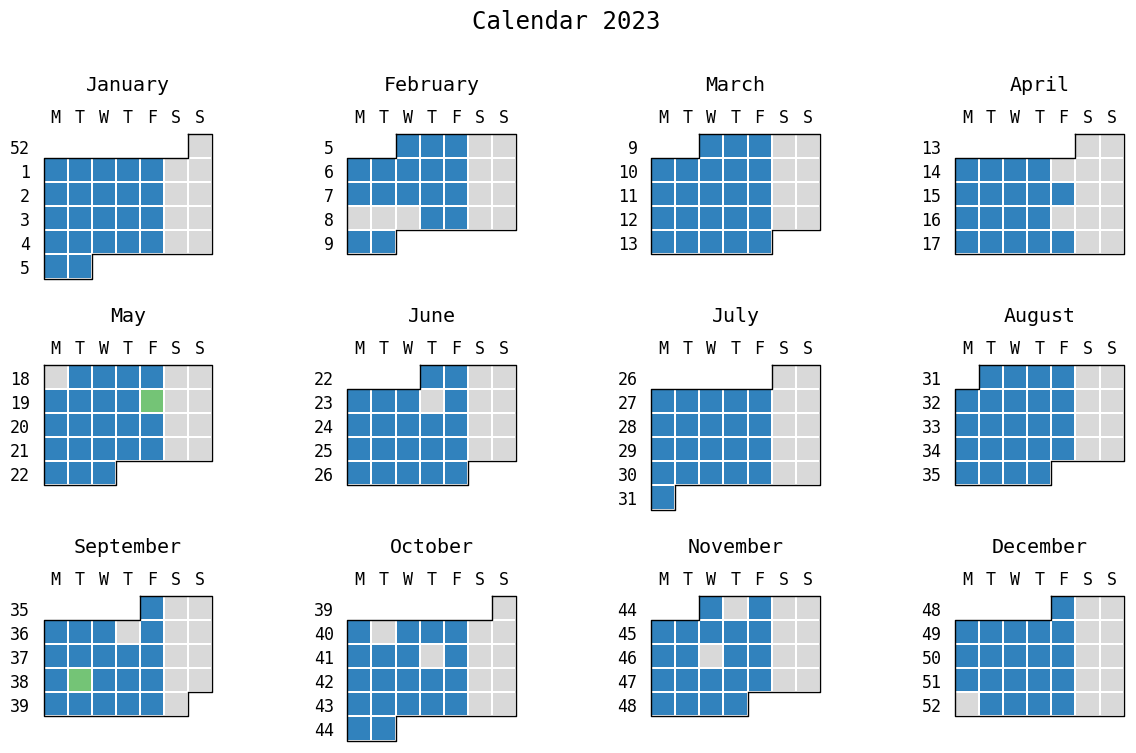

In [ ]:
import july

start = datetime(2023, 1, 1)
end = datetime(2023, 12, 31)

dates = pd.date_range(start, end)
dia_nao_util = pd.date_range(start, end).difference(dia_util)

day_data = df_abastecimento.iloc[ordem_beneficiaros[3000],:].values

# on dia não util, -1, on abastecimento, 1, senão 0
day_data = np.where(day_data == 1, 0, 1)
day_data = np.where(np.isin(dates,dia_nao_util), -1, day_data)


# plot
july.calendar_plot(
    dates = dates, # type: ignore
    data = day_data, # type: ignore
    cmap = 'tab20c_r'
    )
